In [1]:
import os
import pandas as pd
import numpy as np
import sys
from datetime import datetime

from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer

from xgboost import XGBRegressor

import joblib

from lib.customTransformers import (featureDropTransformer, featureLogTransformer, featureFloatTransformer, upperTextTransformer, valueGroupTransformer,
    replaceNaTransformer, medianImputationTransformer, gfaFixTransformer, numRangeCatTransformer, numFeatureBounderTransformer, ratioMakerTransformer,
    featureMultiplierImputerTransformer, featureAdderTransformer, numFeaturesImputerTransformer, catFeaturesImputerTransformer, numFeaturesScalerTransformer,
    catFeaturesEncoderTransformer, queryTransformer, debugTransformer)


from scipy.stats import kurtosis

from IPython.display import Markdown as md, display, HTML

import plotly.graph_objects as go
import plotly.express as px

from warnings import simplefilter
if not sys.warnoptions:
    simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
    
from lib import pipeUtils

working_dir = "working"
if not os.path.exists(working_dir):
    os.mkdir(working_dir)


pd.set_option('display.max_columns', None)



In [2]:
df_benchmark_filename = f"""{working_dir}/df_benchmark_ghgemissionsintensity.parquet"""
if os.path.exists(df_benchmark_filename):
    os.rename(df_benchmark_filename, f"""{df_benchmark_filename}_{datetime.now().strftime("%Y%m%d_%H%M%S")}""")
    

# Chargement des données initiales

In [3]:
df = pd.read_csv("assets/2016_Building_Energy_Benchmarking.csv")

# On supprime les immeubles d'habitation
df = df.loc[~df["BuildingType"].str.lower().str.contains("family")].reset_index(drop=True)
df = df.loc[~df["PrimaryPropertyType"].str.lower().str.contains("family")].reset_index(drop=True)

# On s'assure que les target features sont bien renseignées
df = df.loc[~df["SiteEUIWN(kBtu/sf)"].isna() & (df["SiteEUIWN(kBtu/sf)"]>0)]
df = df.loc[~df["TotalGHGEmissions"].isna() & (df["TotalGHGEmissions"]>0)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1635 entries, 0 to 1664
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1635 non-null   int64  
 1   DataYear                         1635 non-null   int64  
 2   BuildingType                     1635 non-null   object 
 3   PrimaryPropertyType              1635 non-null   object 
 4   PropertyName                     1635 non-null   object 
 5   Address                          1635 non-null   object 
 6   City                             1635 non-null   object 
 7   State                            1635 non-null   object 
 8   ZipCode                          1619 non-null   float64
 9   TaxParcelIdentificationNumber    1635 non-null   object 
 10  CouncilDistrictCode              1635 non-null   int64  
 11  Neighborhood                     1635 non-null   object 
 12  Latitude            

# Modèles à estimer

In [78]:
rfr = RandomForestRegressor(n_estimators=750)

estimators = [
    {
        "name": "baseline",
        "estimator": DummyRegressor(),
        "params": {
            'baseline__strategy':['median'], 
        },
        "cv": 5
    },
    {
        "name": "knn",
        "estimator": KNeighborsRegressor(),
        "params": {
            'knn__n_neighbors':range(1,20), 
            'knn__weights' :['uniform','distance'],
            'knn__n_jobs': [-1]
        },
        "cv": 5
    },
    {
        "name": "linear",
        "estimator": LinearRegression(),
        "params": {
            'linear__fit_intercept': [True, False],
        },
        "cv": 5
    },
    {
        "name": "elasticnet",
        "estimator": ElasticNet(),
        "params": {
            "elasticnet__alpha": np.logspace(-4, 4, 9), 
            "elasticnet__l1_ratio": np.arange(0.0, 1.0, 0.05),
            "elasticnet__fit_intercept": [True, False],
        },
        "cv": 5
    },
    {
        "name": "linearsvr",
        "estimator": LinearSVR(),
        "params": {
            "linearsvr__C": np.logspace(-5, 5, 11)
        },
        "cv": 5
    },
    {
        "name": "kernelridge",
        "estimator": KernelRidge(),
        "params": { 
            #"kernelridge__kernel": ['poly', 'cosine', 'rbf', 'laplacian', 'polynomial', 'linear', 'chi2', 'sigmoid', 'precomputed', 'additive_chi2'],
            "kernelridge__alpha": np.logspace(-4,0,7), 
            "kernelridge__kernel": ["rbf",],
            "kernelridge__degree": [2,3,4,5],
            "kernelridge__gamma": np.logspace(-4,0,7)
        },
        "cv": 5
    },
    {
        "name": "randomforest",
        "estimator": RandomForestRegressor(),
        "params": { 
            "randomforest__n_estimators": range(750, 1250, 50) 
        },
        "cv": 5
    },
    {
        "name": "adaboost",
        "estimator": AdaBoostRegressor(),
        "params": { 
            "adaboost__n_estimators": [2, 5, 10, 50, 100] 
        },
        "cv": 5
    },
    {
        "name": "xgb",
        "estimator": XGBRegressor(),
        "params": {
            'xgb__max_depth':range(3,10), 
            'xgb__booster' :['gbtree','dart'],
            'xgb__n_jobs': [1],
            'xgb__gamma': range(1,10)
            
        },
        "cv": 5
    },
]


xestimators = [
    {
        "name": "xgb",
        "estimator": XGBRegressor(),
        "params": {
            'xgb__max_depth':range(3,10), 
            'xgb__booster' :['gbtree','dart'],
            'xgb__n_jobs': [1],
            'xgb__gamma': range(1,10)
            
        },
        "cv": 5
    },
]

# Préparation des données

In [5]:
df_benchmark = pd.DataFrame(columns=[
    "target", 
    "use_largest_property_type", "use_energy_star_score", "use_lat_lon", "use_log", 
    "estimator", "params", "r2_train", "rmse_train", "r2_test", "rmse_test"
])

df_benchmark.to_parquet(df_benchmark_filename)

In [42]:
clean_impute_pipe_arr = []
num_preprocessor_pipeline_arr = []
cat_preprocessor_pipeline_arr = []
preprocessor_ct_arr = []
preprocessor_pipe_arr = []
pipeline_arr = []
grid_pipeline_arr = []

def evaluate(X_train0, X_test0, y_train0, y_test0, use_log=False, use_lat_lon=False, use_property_types=False, use_energy_star_score=False, 
             save_model=False, skip_results_output=False, ghg_optimization_column=False,
             estimators = [], clip_to_min = None, clip_to_max = None):
    global clean_impute_pipe_arr, num_preprocessor_pipeline_arr, cat_preprocessor_pipeline_arr
    global preprocessor_ct_arr, preprocessor_pipe_arr, pipeline_arr, grid_pipeline_arr
    global df_benchmark
    
    current_index = len(clean_impute_pipe_arr)
    
    cat_features = X_train0.select_dtypes(include=["object"]).columns

    median_imputer_ref_cols_groups = [
        ["PrimaryPropertyType", "BuildingType", "Neighborhood", "YearBuilt"],
        ["PrimaryPropertyType", "BuildingType", "Neighborhood"],
        ["PrimaryPropertyType", "Neighborhood", "YearBuilt"],
        ["PrimaryPropertyType", "Neighborhood"],
        ["PrimaryPropertyType", "BuildingType", "YearBuilt"],
        ["PrimaryPropertyType", "BuildingType"],
        ["PrimaryPropertyType", "YearBuilt"],
        ["PrimaryPropertyType"],
        ["BuildingType", "YearBuilt"],
        ["BuildingType"]
    ]

    drop_features_base = [
        "OSEBuildingID", "DataYear", "PropertyName", "Address", "City", "State", "ZipCode", "TaxParcelIdentificationNumber", 
        "CouncilDistrictCode",  "YearsENERGYSTARCertified", "DefaultData", 
        "Comments", "ComplianceStatus", "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)", "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)",
        "SteamUse(kBtu)", "Electricity(kWh)", "Electricity(kBtu)", "NaturalGas(therms)", "NaturalGas(kBtu)", "TotalGHGEmissions",
        "SiteEUI(kBtu/sf)", "Outlier",  
        "ListOfAllPropertyUseTypes"
    ]
    
    drop_features_property_use_types = [ "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType" ]
    drop_features_energy_star_score = ["ENERGYSTARScore"]
    drop_features_lat_lon = ["Latitude", "Longitude"]

    drop_f = drop_features_base
    if not use_lat_lon:
        drop_f = drop_f + drop_features_lat_lon
    if not use_property_types:
        drop_f = drop_f + drop_features_property_use_types
    if not use_energy_star_score:
        drop_f = drop_f + drop_features_energy_star_score
        
    clean_impute_pipe_arr.append(Pipeline(
        steps=[
            #("deb_ini", debugTransformer("DEB BEG OF CLEAN IMPUTE: ", "X")),
            (f"upper_str_{current_index}", upperTextTransformer(cat_features)),
            (f"year_built_five_years_{current_index}", numRangeCatTransformer("YearBuilt", "YearBuilt", 5)),
            (f"values_to_group_{current_index}", valueGroupTransformer(["BuildingType", "Neighborhood"], [["NONRESIDENTIAL"], ["DELRIDGE"]])),
            (f"largest_property_gfa_bounder_{current_index}", numFeatureBounderTransformer([["LargestPropertyUseTypeGFA", 0, None]])),
            (f"parking_ratio_create_{current_index}", ratioMakerTransformer([["parking_ratio", "PropertyGFAParking", "PropertyGFABuilding(s)"]])),
            (f"bounder_0_{current_index}", numFeatureBounderTransformer([
                ["LargestPropertyUseTypeGFA", 0, None],
                ["ThirdLargestPropertyUseTypeGFA", 0, None],
                ["NumberofBuildings", 1, 76],
                ["parking_ratio", 0, 4]
            ])),
            (f"fill_na_property_gfa_{current_index}", replaceNaTransformer(["SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA", "SteamUse(kBtu)"], 0)),
            (f"fill_na_property_type_{current_index}", replaceNaTransformer(["SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"], "")),
            (f"primary_property_type_imputer_{current_index}", medianImputationTransformer(
                ["PrimaryPropertyType", "LargestPropertyUseType", "PropertyGFABuilding(s)", "parking_ratio", "NumberofBuildings"], 
                median_imputer_ref_cols_groups
            )),
            (f"gfa_fixer_{current_index}", gfaFixTransformer("PropertyGFATotal", ["LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"])),
            (f"gfa_parking_fixer_{current_index}", gfaFixTransformer("PropertyGFATotal", ["PropertyGFAParking", "PropertyGFABuilding(s)"])),
            (f"electricity_conversion_imputer_{current_index}", featureMultiplierImputerTransformer("Electricity(kBtu)", "Electricity(kWh)", 3.413)),
            (f"gas_conversion_imputer_{current_index}", featureMultiplierImputerTransformer("NaturalGas(kBtu)", "NaturalGas(therms)", 99.976)),
            (f"bounder_1_{current_index}", numFeatureBounderTransformer([
                ["NaturalGas(kBtu)", 0, None],
                ["Electricity(kBtu)", 0, None],
                ["SteamUse(kBtu)", 1, 76],
                ["SiteEnergyUse(kBtu)", 0, 4]
            ])),
            (f"energy_adder_{current_index}", featureAdderTransformer("SiteEnergyUse(kBtu)", ["NaturalGas(kBtu)", "Electricity(kBtu)", "SteamUse(kBtu)"])),
            (f"electricity_ratio_create_{current_index}", ratioMakerTransformer([
                    ["electricity_ratio", "Electricity(kBtu)", "SiteEnergyUse(kBtu)"],
                    ["gas_ratio", "NaturalGas(kBtu)", "SiteEnergyUse(kBtu)"],
                    ["steam_ratio", "SteamUse(kBtu)", "SiteEnergyUse(kBtu)"]
                ]
            )),

            (f"drop_{current_index}", featureDropTransformer(drop_f)),
            #("deb_ini", debugTransformer("END BEG OF CLEAN IMPUTE: ", "X.columns")),

        ]
    ))

    num_preprocessor_pipeline_arr.append(Pipeline(
        steps = [
            (f"num_impute_{current_index}", SimpleImputer(strategy="median")),
            (f"num_scaler_{current_index}", StandardScaler()),
        ]
    ))
    cat_preprocessor_pipeline_arr.append(Pipeline(
        steps = [
            (f"cat_imputer_{current_index}", SimpleImputer(strategy="constant", fill_value='missing')),
            (f"cat_encoder_{current_index}", OneHotEncoder(handle_unknown='ignore', sparse=False)),
        ]
    ))

    cat_cols = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "YearBuilt"]
    num_cols = ["NumberofBuildings", "NumberofFloors", "PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)", 
                "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA", 
                "parking_ratio", "electricity_ratio", "gas_ratio", "steam_ratio"
    ]
    if ghg_optimization_column is not None:
        num_cols.append(ghg_optimization_column)
        
    if use_property_types:
        cat_cols += drop_features_property_use_types
    if use_lat_lon:
        num_cols += drop_features_lat_lon
    if use_energy_star_score:
        num_cols += drop_features_energy_star_score

        
    preprocessor_ct_arr.append(ColumnTransformer(transformers = [
        ('cat_{current_index}', cat_preprocessor_pipeline_arr[current_index], cat_cols),
        ('num_{current_index}', num_preprocessor_pipeline_arr[current_index], num_cols)
    ]))

    if use_log:
        preprocessor_pipe_arr.append(Pipeline(
            steps = [
                (f"clean_impute_{current_index}", clean_impute_pipe_arr[current_index]),
                (f"log_{current_index}", featureLogTransformer()),
                (f"preprocessor{current_index}", preprocessor_ct_arr[current_index]),
            ]
        ))
        y_train = np.log1p(y_train0.copy())
        y_test = y_test0
    else:
        preprocessor_pipe_arr.append(Pipeline(
            steps = [
                (f"clean_impute_{current_index}", clean_impute_pipe_arr[current_index]),
                #(f"log_{current_index}", featureLogTransformer()),
                (f"preprocessor{current_index}", preprocessor_ct_arr[current_index]),
            ]
        ))
        y_train = y_train0.copy()
        y_test = y_test0.copy()
        
    pipeline_arr.append(Pipeline(
        steps = [
            ("prepare", preprocessor_pipe_arr[current_index]),
        ]
    ))

    for estimator in estimators:
        X_train = X_train0.copy()
        X_test = X_test0.copy()
        #print(X_train.head())
        pipeline_arr[current_index].steps.append(( estimator["name"] , estimator["estimator"] ))
        grid_pipeline =GridSearchCV(
                pipeline_arr[current_index], 
                param_grid=estimator["params"], 
                cv=estimator["cv"], 
                n_jobs=-1, 
                scoring='r2', 
                error_score='raise', 
                verbose=False
            )
        
        grid_pipeline.fit(X_train,y_train)
        best_params = grid_pipeline.best_params_

        X_train = X_train0.copy()
        y_predict_train = grid_pipeline.predict(X_train)
        if use_log:
            y_predict_train = np.expm1(y_predict_train)
        y_predict_train = np.clip(y_predict_train, clip_to_min, clip_to_max)
            
        r2_train=r2_score(y_train0,y_predict_train)
        rmse_train=np.sqrt(mean_squared_error(y_train,y_predict_train))

        y_predict_test = grid_pipeline.predict(X_test)
        if use_log:
            y_predict_test = np.expm1(y_predict_test)
        y_predict_test = np.clip(y_predict_test, clip_to_min, clip_to_max) 
            
        r2_test=r2_score(y_test,y_predict_test)
        rmse_test=np.sqrt(mean_squared_error(y_test,y_predict_test))

        benchmark_row = {
            "target": target,
            "use_largest_property_type": 1 if use_property_types else 0,
            "use_lat_lon": 1 if use_lat_lon else 0,
            "use_energy_star_score":  1 if use_energy_star_score else 0,
            "use_log": 1 if use_log else 0,
            "estimator": estimator["name"],
            "params": best_params,
            "r2_train": r2_train,
            "r2_test": r2_test,
            "rmse_train": rmse_train,
            "rmse_test": rmse_test
        }
        if skip_results_output==False:
            df_benchmark = df_benchmark.append(benchmark_row, ignore_index=True)
            df_benchmark.to_parquet(df_benchmark_filename)

        print(f"""{estimator["name"]}: {r2_train} / {r2_test} """)
        
        if save_model==True:
            model_filename = f"""{working_dir}/best_ghg_model_{estimator["name"]}_use_lat_lon_{"1" if use_lat_lon else "0"}_use_property_types_{"1" if use_property_types else "0"}_use_energy_star_score_{"1" if use_energy_star_score else "0"}.pkl"""
            joblib.dump(grid_pipeline.best_estimator_, model_filename, compress = 1) # Only best parameters
            print(f"Modème enregistré sous: {model_filename}")
            
        pipeline_arr[current_index].steps.pop()


# Modélisation de GHGEmissionsIntensity

In [7]:
target = "GHGEmissionsIntensity"

In [8]:
X = df.drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])
y = df[target]

X_train0, X_test0, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

## Calcul initial

In [9]:
y.max()

34.09

In [10]:
evaluate(X_train0, X_test0, y_train, y_test, use_log=False, use_property_types=False, use_energy_star_score=False, estimators = estimators, 
         clip_to_min=0, clip_to_max=100)

baseline: -0.10663885809935691 / -0.08573489336776108 
knn: 0.9999999999999976 / 0.10120449083660188 
linear: 0.3457362300486697 / 0.39491032551993566 
elasticnet: 0.3448529630387269 / 0.3859432839092318 
linearsvr: 0.24974962917192345 / 0.249467229261627 
kernelridge: 0.42888393668077507 / 0.18117042321972576 
randomforest: 0.8954224144025913 / 0.2015819194546422 
adaboost: 0.19420645056661845 / 0.09120078462741732 
xgb: 0.6488399110295864 / 0.22908574554808503 


In [11]:
evaluate(X_train0, X_test0, y_train, y_test, use_log=False, use_property_types=True, use_energy_star_score=False, estimators=estimators, 
         clip_to_min=0, clip_to_max=100)

baseline: -0.10663885809935691 / -0.08573489336776108 
knn: 0.9999999999999996 / 0.13385939944934755 
linear: 0.5059895285704377 / -40.10238371689798 
elasticnet: 0.40232577537885617 / 0.37098240852901576 
linearsvr: 0.3578896779689209 / 0.28542627183420965 
kernelridge: 0.5903413628034333 / 0.22622087494024923 
randomforest: 0.9011518391199388 / 0.24238391991095576 
adaboost: 0.23072230887202194 / 0.09632599165463518 
xgb: 0.7797193460851978 / 0.18331165271854266 


In [12]:
evaluate(X_train0, X_test0, y_train, y_test, use_log=True, use_property_types=True, use_energy_star_score=False, 
         estimators=estimators, clip_to_min=0, clip_to_max=100)

baseline: -0.10663885809935691 / -0.08573489336776108 
knn: 0.999999999999942 / 0.10997674301003613 
linear: 0.45577440029786487 / -15.186502469089213 
elasticnet: 0.29847245282353263 / 0.19422701253206043 
linearsvr: 0.29429005495370797 / 0.19577899275216826 
kernelridge: 0.5231810285773321 / 0.2277096453840114 
randomforest: 0.8347238664610439 / 0.19471304391369992 
adaboost: 0.10293844019542298 / 0.04051964132683872 
xgb: 0.4995959598299735 / 0.14778668391048422 


In [13]:
evaluate(X_train0, X_test0, y_train, y_test, use_log=True, use_property_types=False, use_energy_star_score=False, 
         estimators=estimators, clip_to_min=0, clip_to_max=100)

baseline: -0.10663885809935691 / -0.08573489336776108 
knn: 0.9999999999998621 / 0.030053106315933498 
linear: 0.2959893949123761 / 0.22303719944984057 
elasticnet: 0.27114164180439915 / 0.18952233012258513 
linearsvr: 0.2569627732688258 / 0.18683120998664826 
kernelridge: 0.31501916258408 / 0.18212591409432 
randomforest: 0.8209625363821809 / 0.17557902886055665 
adaboost: 0.047949801944726644 / 0.004939993093690198 
xgb: 0.5137349183076072 / 0.14517210227202215 


## Prise en compte de ENERGYSTARScore

In [14]:
df = pd.read_csv("assets/2016_Building_Energy_Benchmarking.csv")

# On supprime les immeubles d'habitation
df = df.loc[~df["BuildingType"].str.lower().str.contains("family")].reset_index(drop=True)
df = df.loc[~df["PrimaryPropertyType"].str.lower().str.contains("family")].reset_index(drop=True)

# On s'assure que les target features sont bien renseignées
df = df.loc[~df["SiteEUIWN(kBtu/sf)"].isna() & (df["SiteEUIWN(kBtu/sf)"]>0)]
df = df.loc[~df["TotalGHGEmissions"].isna() & (df["TotalGHGEmissions"]>0)]

X = df.loc[~df["ENERGYSTARScore"].isna()].drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])
y = df.loc[~df["ENERGYSTARScore"].isna(), target]

X_train0, X_test0, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [15]:
evaluate(X_train0, X_test0, y_train, y_test, use_log=False, use_property_types=False, use_energy_star_score=True, estimators = estimators, clip_to_min=0, clip_to_max=100)
evaluate(X_train0, X_test0, y_train, y_test, use_log=False, use_property_types=True, use_energy_star_score=True, estimators=estimators, clip_to_min=0, clip_to_max=100)
evaluate(X_train0, X_test0, y_train, y_test, use_log=True, use_property_types=False, use_energy_star_score=True, estimators=estimators, clip_to_min=0, clip_to_max=100)
evaluate(X_train0, X_test0, y_train, y_test, use_log=True, use_property_types=True, use_energy_star_score=True, estimators=estimators, clip_to_min=0, clip_to_max=100)

baseline: -0.10048720984151749 / -0.13510404195449488 
knn: 0.9999999999999865 / 0.3167390877459558 
linear: 0.6794704200702655 / 0.31850745858638496 
elasticnet: 0.6780844697467565 / 0.33223110833855685 
linearsvr: 0.4005684232451201 / 0.3606496425948863 
kernelridge: 0.7028210700279267 / 0.36273311307898937 
randomforest: 0.9129646701206946 / 0.3740958588577238 
adaboost: 0.5619901634536714 / 0.18798057260431222 
xgb: 0.9301721984917665 / 0.4377177902716535 
baseline: -0.10048720984151749 / -0.13510404195449488 
knn: 0.999999999999994 / 0.36247905615662057 
linear: 0.7438589455767923 / -21.59294126794694 
elasticnet: 0.7367221492522562 / 0.2778537879680334 
linearsvr: 0.4681276103793919 / 0.34350748760604033 
kernelridge: 0.744571389466715 / 0.3225732478607358 
randomforest: 0.906719619492472 / 0.30862357680770547 
adaboost: 0.48090973358531675 / 0.3043374435362495 
xgb: 0.9061265249692196 / 0.40730215864549846 
baseline: -0.10048720984151749 / -0.13510404195449488 
knn: 0.9999999999

In [16]:
df_benchmark = pd.read_parquet(f"{working_dir}/df_benchmark_ghgemissionsintensity.parquet")
df_benchmark.loc[df_benchmark["estimator"]=="randomforest"].sort_values(["estimator", "use_largest_property_type","use_log","use_energy_star_score"]).head(50)

,target,use_largest_property_type,use_energy_star_score,use_lat_lon,use_log,estimator,params,r2_train,rmse_train,r2_test,rmse_test
6,GHGEmissionsIntensity,0,0,0,0,randomforest,{'randomforest__n_estimators': 1100},0.895422,0.689651,0.201582,2.745376
42,GHGEmissionsIntensity,0,1,0,0,randomforest,{'randomforest__n_estimators': 1100},0.912965,0.607521,0.374096,1.147409
33,GHGEmissionsIntensity,0,0,0,1,randomforest,{'randomforest__n_estimators': 1000},0.820963,1.148486,0.175579,2.789723
60,GHGEmissionsIntensity,0,1,0,1,randomforest,{'randomforest__n_estimators': 750},0.801421,1.096906,0.415708,1.108612
15,GHGEmissionsIntensity,1,0,0,0,randomforest,{'randomforest__n_estimators': 1200},0.901152,0.670493,0.242384,2.674306
51,GHGEmissionsIntensity,1,1,0,0,randomforest,{'randomforest__n_estimators': 900},0.906720,0.628939,0.308624,1.205929
24,GHGEmissionsIntensity,1,0,0,1,randomforest,{'randomforest__n_estimators': 1200},0.834724,1.166644,0.194713,2.757160
69,GHGEmissionsIntensity,1,1,0,1,randomforest,{'randomforest__n_estimators': 1150},0.785208,1.081974,0.409855,1.114150


In [17]:
df_benchmark.sort_values("r2_test", ascending=False)

,target,use_largest_property_type,use_energy_star_score,use_lat_lon,use_log,estimator,params,r2_train,rmse_train,r2_test,rmse_test
44,GHGEmissionsIntensity,0,1,0,0,xgb,"{'xgb__booster': 'dart', 'xgb__gamma': 1, 'xgb...",0.930172,0.544161,0.437718,1.087531
60,GHGEmissionsIntensity,0,1,0,1,randomforest,{'randomforest__n_estimators': 750},0.801421,1.096906,0.415708,1.108612
59,GHGEmissionsIntensity,0,1,0,1,kernelridge,"{'kernelridge__alpha': 0.002154434690031882, '...",0.465947,0.936776,0.413811,1.110410
69,GHGEmissionsIntensity,1,1,0,1,randomforest,{'randomforest__n_estimators': 1150},0.785208,1.081974,0.409855,1.114150
53,GHGEmissionsIntensity,1,1,0,0,xgb,"{'xgb__booster': 'dart', 'xgb__gamma': 2, 'xgb...",0.906127,0.630935,0.407302,1.116557
...,...,...,...,...,...,...,...,...,...,...,...
36,GHGEmissionsIntensity,0,1,0,0,baseline,{'baseline__strategy': 'median'},-0.100487,2.160259,-0.135104,1.545191
20,GHGEmissionsIntensity,1,0,0,1,linear,{'linear__fit_intercept': True},0.455774,1.095651,-15.186502,12.361270
47,GHGEmissionsIntensity,1,1,0,0,linear,{'linear__fit_intercept': False},0.743859,1.042205,-21.592941,6.893674
11,GHGEmissionsIntensity,1,0,0,0,linear,{'linear__fit_intercept': False},0.505990,1.498919,-40.102384,19.697907


In [53]:
df_benchmark["features"] = "basique"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==0) & (df_benchmark["use_log"]==0) & (df_benchmark["use_largest_property_type"]==0)]["features"] = "basique"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==0) & (df_benchmark["use_log"]==0) & (df_benchmark["use_largest_property_type"]==1), "features"] = "basique+property_type"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==0) & (df_benchmark["use_log"]==1) & (df_benchmark["use_largest_property_type"]==0), "features"] = "basique+log"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==0) & (df_benchmark["use_log"]==1) & (df_benchmark["use_largest_property_type"]==1), "features"] = "basique+property_type+log"

df_benchmark.loc[(df_benchmark["use_energy_star_score"]==1) & (df_benchmark["use_log"]==0) & (df_benchmark["use_largest_property_type"]==0), "features"] = "basique+energy_score"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==1) & (df_benchmark["use_log"]==0) & (df_benchmark["use_largest_property_type"]==1), "features"] = "basique+property_type+energy_score"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==1) & (df_benchmark["use_log"]==1) & (df_benchmark["use_largest_property_type"]==0), "features"] = "basique+log+energy_score"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==1) & (df_benchmark["use_log"]==1) & (df_benchmark["use_largest_property_type"]==1), "features"] = "basique+property_type+log+energy_score"

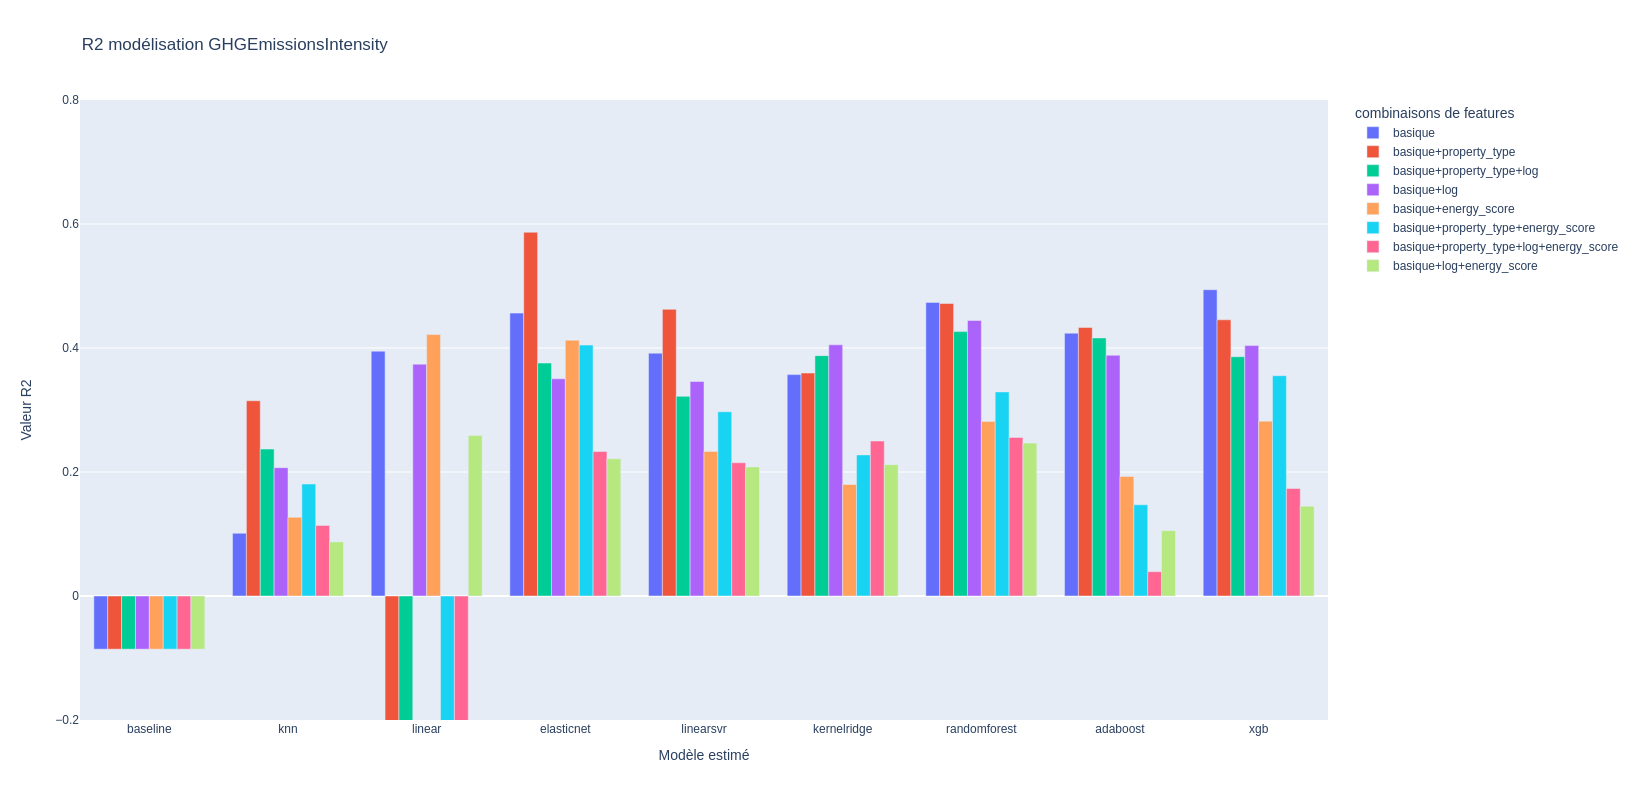

In [55]:
estimator_names=[estimator["name"] for estimator in estimators]
fig_data = []
for c in df_benchmark["features"].unique():
    y = []
    for e in estimator_names:
        y.append(df_benchmark.loc[(df_benchmark["estimator"]==e) & (df_benchmark["features"]==c)]["r2_test"].iloc[0])
    fig_data.append(
        go.Bar(name=c, x=estimator_names, y=y)
    )

fig = go.Figure(data=fig_data)
# Change the bar mode
fig.update_layout(
    barmode='group', 
    yaxis_range=[-0.2,0.8], 
    height=800,
    title=f"R2 modélisation {target}",
    xaxis_title="Modèle estimé",
    yaxis_title="Valeur R2",
    legend_title="combinaisons de features"
)
fig.show()

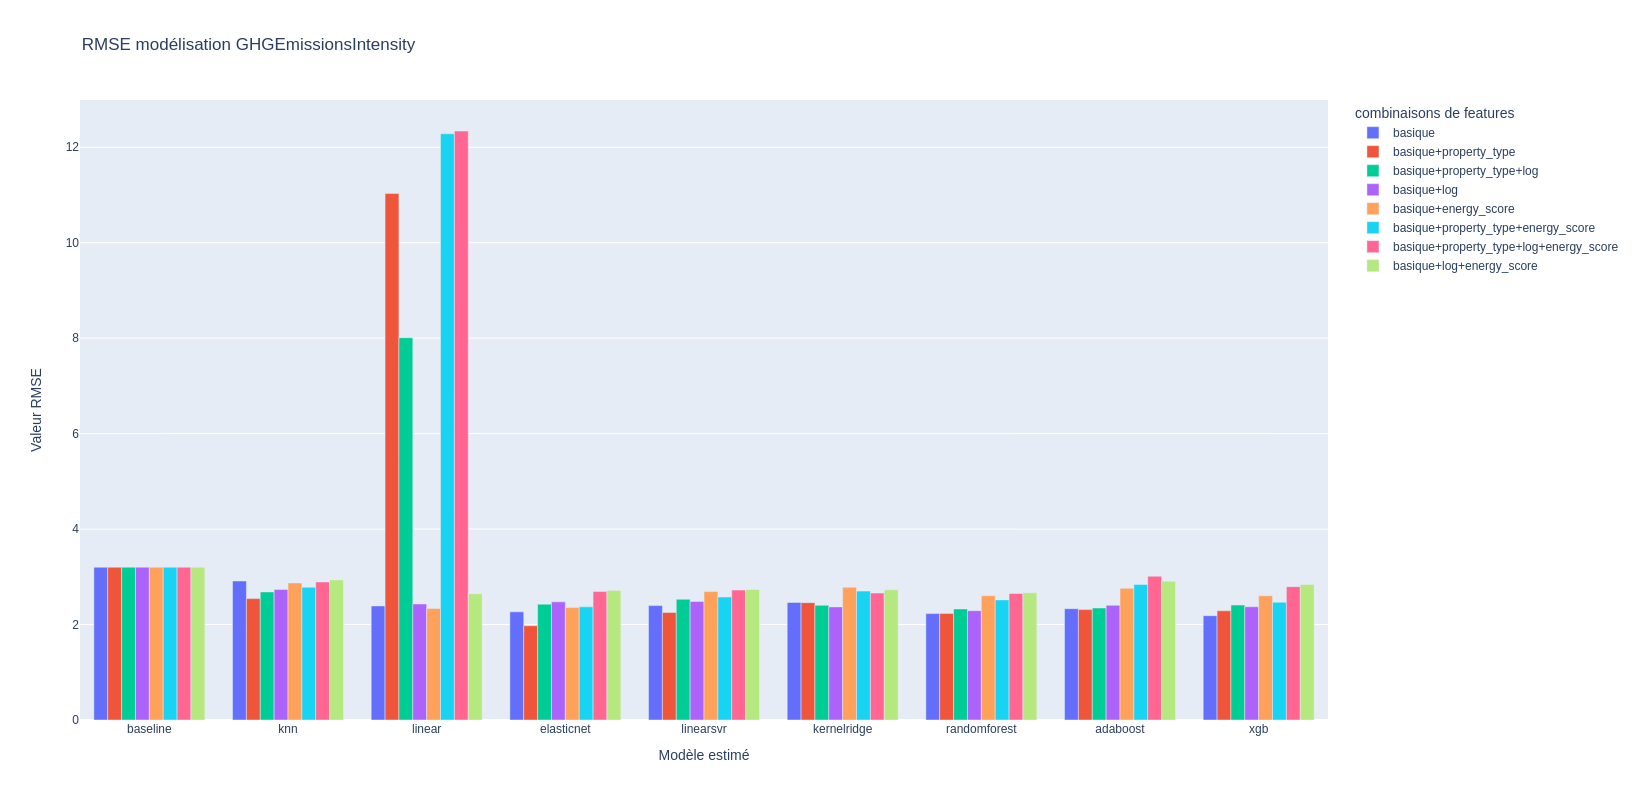

In [56]:
fig_data = []
for c in df_benchmark["features"].unique():
    y = []
    for e in estimator_names:
        y.append(df_benchmark.loc[(df_benchmark["estimator"]==e) & (df_benchmark["features"]==c)]["rmse_test"].iloc[0])
    fig_data.append(
        go.Bar(name=c, x=estimator_names, y=y)
    )

fig = go.Figure(data=fig_data)

fig.update_layout(
    title=f"RMSE modélisation {target}",
    xaxis_title="Modèle estimé",
    yaxis_title="Valeur RMSE",
    legend_title="combinaisons de features",
    height=800
)

fig.show()

# Optimisation

Nous avons vu dans l'analyse exploratoire qu'il y avait une corrélation entre GHGEmissionsIntensity et SiteEUIWN(kBtu/sf).

Nous allons rajouter la prédiction de SiteEUIWN(kBtu/sf) dans le pipeline et estimer la modélisation de GHGEmissionsIntensity



## Sans utilisation de ENERGYSTARScore

Copie de df_benchmark et création d'un nouveau

In [25]:
os.rename(df_benchmark_filename, f"""{df_benchmark_filename}_not_optimized""")

df_benchmark = pd.DataFrame(columns=[
    "target", 
    "use_largest_property_type", "use_energy_star_score", "use_lat_lon", "use_log", 
    "estimator", "params", "r2_train", "rmse_train", "r2_test", "rmse_test"
])

df_benchmark.to_parquet(df_benchmark_filename)

In [43]:
X_ = df.drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])

grid = joblib.load("working/best_siteeuiwn_without_energystarscore.pkl")
X_["predicted_euiwn"] = grid.predict(X_)

X = df.drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])
X["predicted_euiwn"] = X_["predicted_euiwn"]
y = df[target]

X_train0, X_test0, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [44]:

evaluate(X_train0, X_test0, y_train, y_test, use_log=False, use_property_types=False, use_energy_star_score=False, estimators = estimators, 
         ghg_optimization_column='predicted_euiwn', clip_to_min=0, clip_to_max=100)
evaluate(X_train0, X_test0, y_train, y_test, use_log=False, use_property_types=True, use_energy_star_score=False, estimators=estimators, 
         ghg_optimization_column='predicted_euiwn', clip_to_min=0, clip_to_max=100)
evaluate(X_train0, X_test0, y_train, y_test, use_log=True, use_property_types=True, use_energy_star_score=False, 
         ghg_optimization_column='predicted_euiwn', estimators=estimators, clip_to_min=0, clip_to_max=100)
evaluate(X_train0, X_test0, y_train, y_test, use_log=True, use_property_types=False, use_energy_star_score=False, 
         ghg_optimization_column='predicted_euiwn', estimators=estimators, clip_to_min=0, clip_to_max=100)

baseline: -0.10663885809935691 / -0.08573489336776108 
knn: 0.9999999999999954 / 0.29828450262924444 
linear: 0.5605682926964928 / 0.5165245266232033 
elasticnet: 0.5413844754296777 / 0.45631499060872993 
linearsvr: 0.5100080210233024 / 0.39168464390481095 
kernelridge: 0.7313754027181655 / 0.3570863718298968 
randomforest: 0.9413626504953234 / 0.4735827017802362 
adaboost: 0.63944020348054 / 0.42392733895378454 
xgb: 0.7780813775877822 / 0.49404492272325984 
baseline: -0.10663885809935691 / -0.08573489336776108 
knn: 0.9999999999999964 / 0.3149005305315159 
linear: 0.7050725188773308 / -11.891319173072857 
elasticnet: 0.6878094510674282 / 0.586675437317234 
linearsvr: 0.6462027772771297 / 0.46232564392424513 
kernelridge: 0.7073687399050769 / 0.3595878560877366 
randomforest: 0.9392525702248402 / 0.47177816578987897 
adaboost: 0.6052662796380488 / 0.4330923473122862 
xgb: 0.7904051448457958 / 0.44545155133148984 
baseline: -0.10663885809935691 / -0.08573489336776108 
knn: 0.4838162926

## Avec utilisation de ENERGYSTARScore

In [50]:
_X = df.loc[~df["ENERGYSTARScore"].isna()].drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])
_y = df.loc[~df["ENERGYSTARScore"].isna()][target]

grid2 = joblib.load("working/best_siteeuiwn_with_energystarscore.pkl")
_X["predicted_euiwn"] = grid2.predict(_X)

X = df.drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])
X["predicted_euiwn"] = _X["predicted_euiwn"]
y = df[target]

X_train0, X_test0, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [51]:

evaluate(X_train0, X_test0, y_train, y_test, use_log=False, use_property_types=False, use_energy_star_score=True, estimators = estimators, 
         ghg_optimization_column='predicted_euiwn',clip_to_min=0, clip_to_max=100)
evaluate(X_train0, X_test0, y_train, y_test, use_log=False, use_property_types=True, use_energy_star_score=True, estimators=estimators, 
         ghg_optimization_column='predicted_euiwn',clip_to_min=0, clip_to_max=100)
evaluate(X_train0, X_test0, y_train, y_test, use_log=True, use_property_types=True, use_energy_star_score=True, 
         ghg_optimization_column='predicted_euiwn',estimators=estimators, clip_to_min=0, clip_to_max=100)
evaluate(X_train0, X_test0, y_train, y_test, use_log=True, use_property_types=False, use_energy_star_score=True, 
         ghg_optimization_column='predicted_euiwn',estimators=estimators, clip_to_min=0, clip_to_max=100)

baseline: -0.10663885809935691 / -0.08573489336776108 
knn: 0.9999999999999973 / 0.12694438229564842 
linear: 0.37462461718737183 / 0.4216556265872242 
elasticnet: 0.3735425236998635 / 0.41255117942101693 
linearsvr: 0.2796683936931289 / 0.23326520475917845 
kernelridge: 0.48711208604570744 / 0.17982540792728807 
randomforest: 0.9001323606350325 / 0.2815490679149377 
adaboost: 0.26431339840249846 / 0.19292010034065876 
xgb: 0.6553660271814283 / 0.2820139482646238 
baseline: -0.10663885809935691 / -0.08573489336776108 
knn: 0.9999999999999998 / 0.1806116089751041 
linear: 0.5309424392176225 / -14.979896542150255 
elasticnet: 0.43147002443570814 / 0.4046717356295997 
linearsvr: 0.3726993529471423 / 0.2971603342255671 
kernelridge: 0.6378072020298348 / 0.22756012480436594 
randomforest: 0.9063624037537823 / 0.3291959067328091 
adaboost: 0.30063820460818 / 0.1471476187986045 
xgb: 0.6890351601792022 / 0.35533238154442714 
baseline: -0.10663885809935691 / -0.08573489336776108 
knn: 0.999999

In [79]:
df_benchmark["features"] = "basique"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==0) & (df_benchmark["use_log"]==0) & (df_benchmark["use_largest_property_type"]==0)]["features"] = "basique"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==0) & (df_benchmark["use_log"]==0) & (df_benchmark["use_largest_property_type"]==1), "features"] = "basique+property_type"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==0) & (df_benchmark["use_log"]==1) & (df_benchmark["use_largest_property_type"]==0), "features"] = "basique+log"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==0) & (df_benchmark["use_log"]==1) & (df_benchmark["use_largest_property_type"]==1), "features"] = "basique+property_type+log"

df_benchmark.loc[(df_benchmark["use_energy_star_score"]==1) & (df_benchmark["use_log"]==0) & (df_benchmark["use_largest_property_type"]==0), "features"] = "basique+energy_score"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==1) & (df_benchmark["use_log"]==0) & (df_benchmark["use_largest_property_type"]==1), "features"] = "basique+property_type+energy_score"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==1) & (df_benchmark["use_log"]==1) & (df_benchmark["use_largest_property_type"]==0), "features"] = "basique+log+energy_score"
df_benchmark.loc[(df_benchmark["use_energy_star_score"]==1) & (df_benchmark["use_log"]==1) & (df_benchmark["use_largest_property_type"]==1), "features"] = "basique+property_type+log+energy_score"

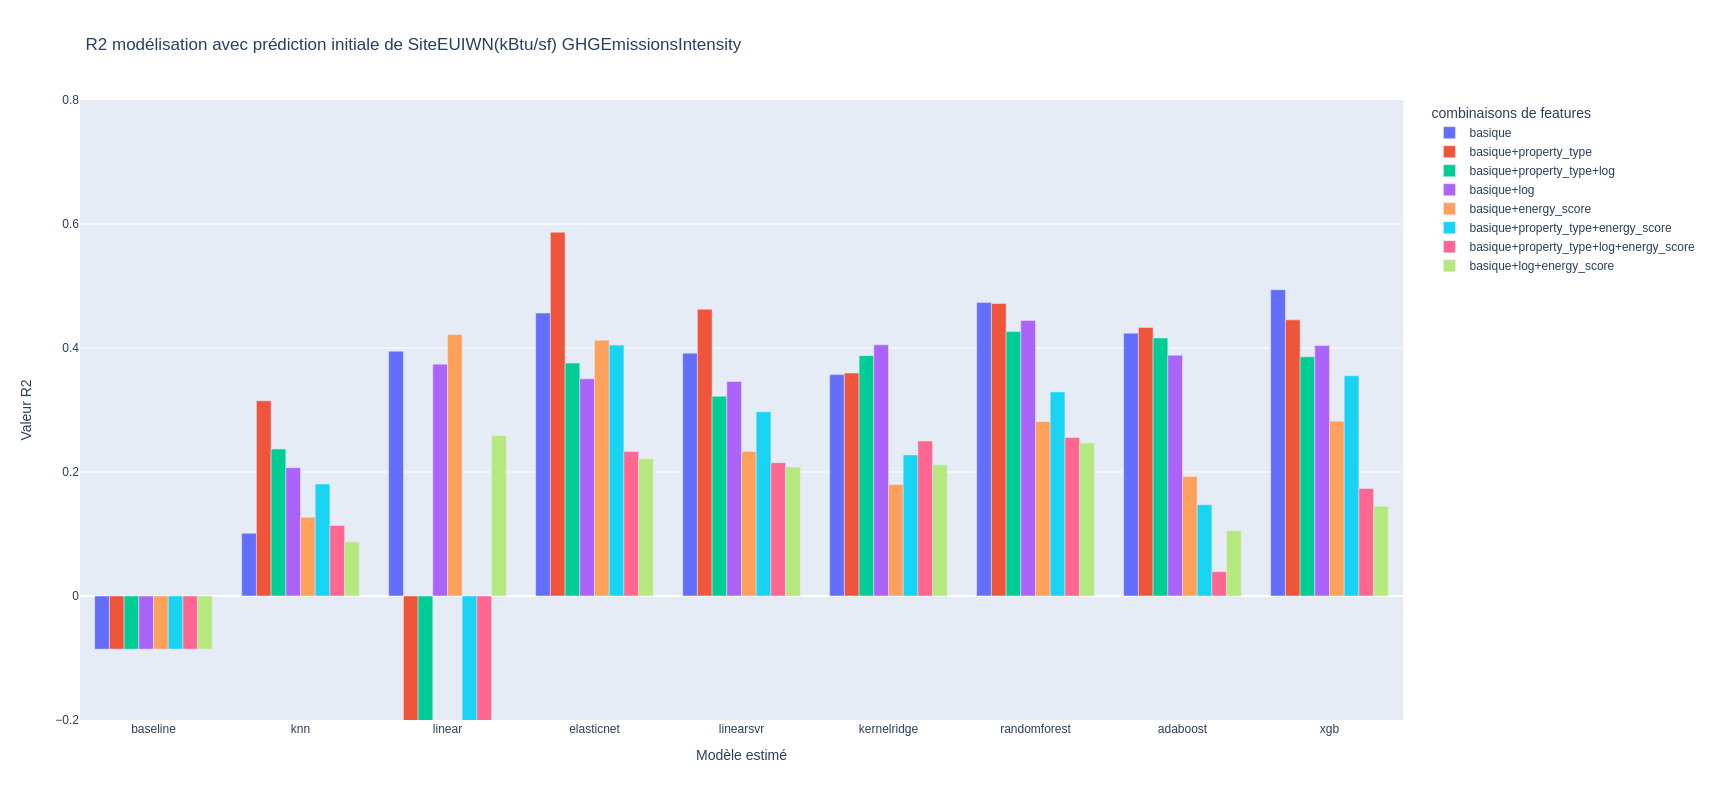

In [82]:
estimator_names=[estimator["name"] for estimator in estimators]
fig_data = []
for c in df_benchmark["features"].unique():
    y = []
    for e in estimator_names:
        y.append(df_benchmark.loc[(df_benchmark["estimator"]==e) & (df_benchmark["features"]==c)]["r2_test"].iloc[0])
    fig_data.append(
        go.Bar(name=c, x=estimator_names, y=y)
    )

fig = go.Figure(data=fig_data)
# Change the bar mode
fig.update_layout(
    barmode='group', 
    yaxis_range=[-0.2,0.8], 
    height=800,
    title=f"R2 modélisation avec prédiction initiale de SiteEUIWN(kBtu/sf) {target}",
    xaxis_title="Modèle estimé",
    yaxis_title="Valeur R2",
    legend_title="combinaisons de features"
)
fig.show()

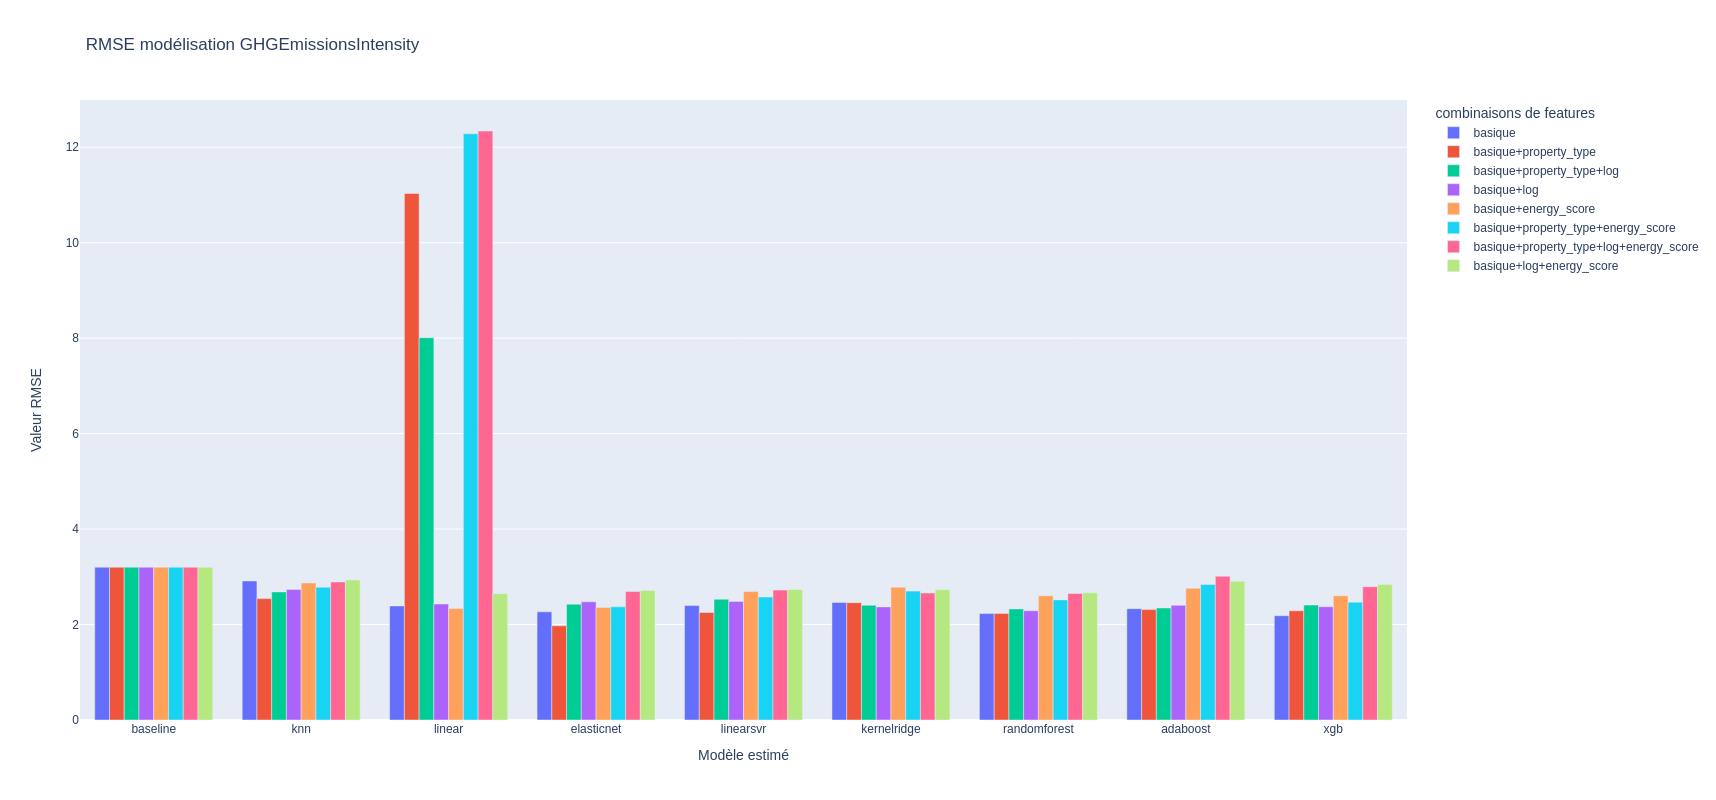

In [83]:
fig_data = []
for c in df_benchmark["features"].unique():
    y = []
    for e in estimator_names:
        y.append(df_benchmark.loc[(df_benchmark["estimator"]==e) & (df_benchmark["features"]==c)]["rmse_test"].iloc[0])
    fig_data.append(
        go.Bar(name=c, x=estimator_names, y=y)
    )

fig = go.Figure(data=fig_data)

fig.update_layout(
    title=f"RMSE modélisation {target}",
    xaxis_title="Modèle estimé",
    yaxis_title="Valeur RMSE",
    legend_title="combinaisons de features",
    height=800
)

fig.show()

In [58]:
df_benchmark.to_parquet(f"{working_dir}/df_benchmark_ghgemissionsintensity.parquet_optimized")

In [66]:
pd.set_option('display.max_colwidth', None)
df_benchmark.loc[df_benchmark["use_energy_star_score"]==0].sort_values("r2_test", ascending=False).head(1)

,target,use_largest_property_type,use_energy_star_score,use_lat_lon,use_log,estimator,params,r2_train,rmse_train,r2_test,rmse_test,features
19,GHGEmissionsIntensity,1,0,0,0,elasticnet,"{'elasticnet__alpha': 0.001, 'elasticnet__fit_intercept': True, 'elasticnet__l1_ratio': 0.8500000000000001}",0.687809,1.191571,0.586675,1.975296,basique+property_type


In [67]:
X_ = df.drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])

grid = joblib.load("working/best_siteeuiwn_without_energystarscore.pkl")
X_["predicted_euiwn"] = grid.predict(X_)

X = df.drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])
X["predicted_euiwn"] = X_["predicted_euiwn"]
y = df[target]

X_train0, X_test0, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

estimators = [
    {
        "name": "elasticnet",
        "estimator": ElasticNet(),
        "params": {
            "elasticnet__alpha": [0.001], 
            "elasticnet__l1_ratio": [0.85],
            "elasticnet__fit_intercept": [True],
        },
        "cv": 5
    },
]
evaluate(X_train0, X_test0, y_train, y_test, use_log=False, use_lat_lon=False, use_property_types=True, use_energy_star_score=False, ghg_optimization_column='predicted_euiwn', save_model=True, skip_results_output=True, estimators = estimators, clip_to_min=0, clip_to_max=1300)



elasticnet: 0.6878094510674282 / 0.5866754373172345 
Modème enregistré sous: working/best_ghg_model_elasticnet_use_lat_lon_0_use_property_types_1_use_energy_star_score_0.pkl


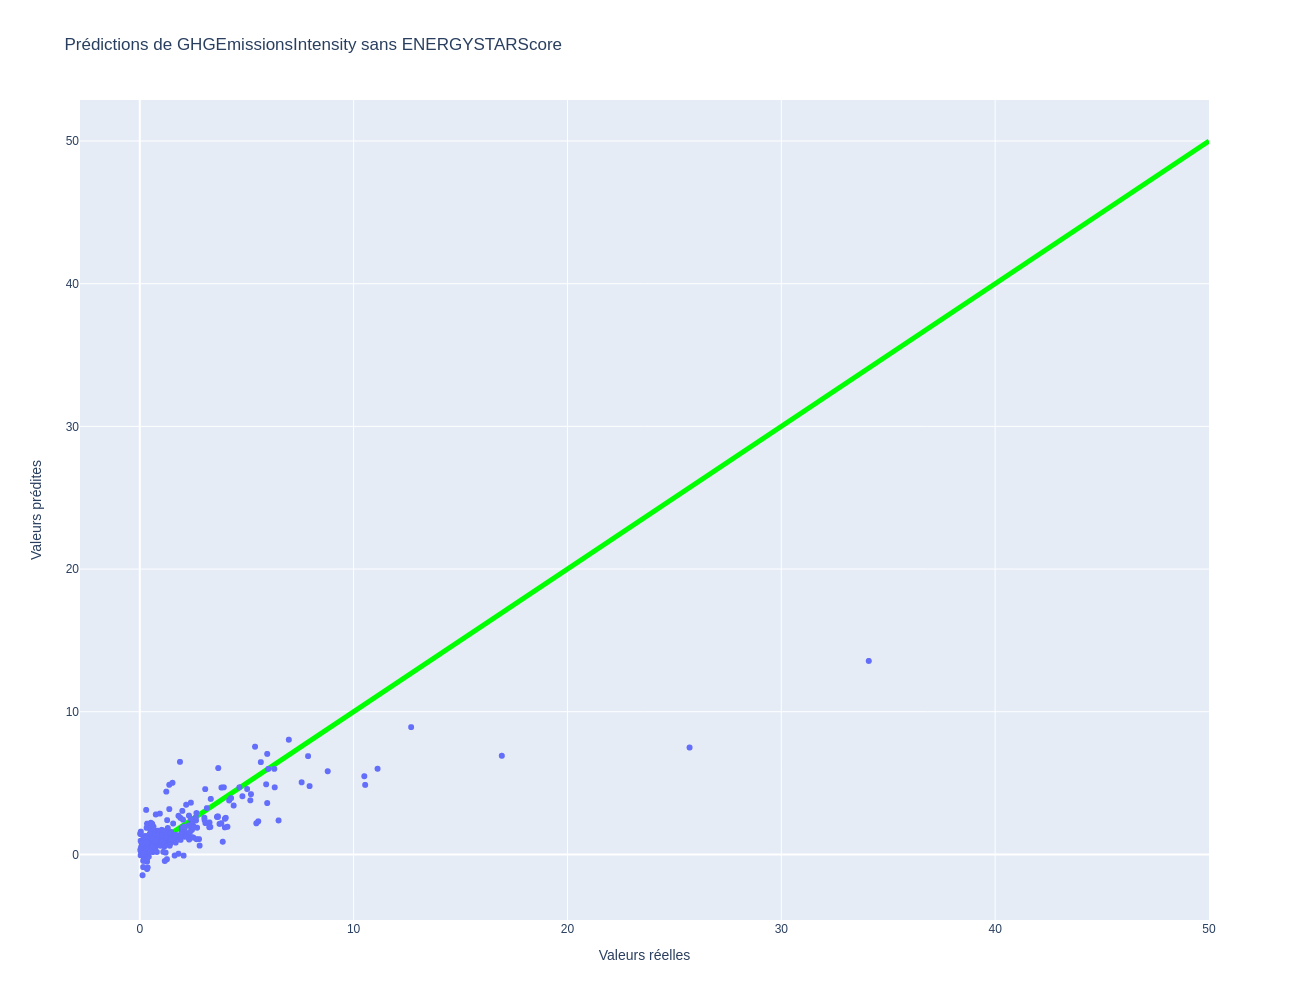

In [71]:
X_ = df.drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])

grid = joblib.load("working/best_siteeuiwn_without_energystarscore.pkl")
X_["predicted_euiwn"] = grid.predict(X_)

X = df.drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])
X["predicted_euiwn"] = X_["predicted_euiwn"]
y = df[target]

X_train0, X_test0, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

grid2 = joblib.load("working/best_ghg_model_elasticnet_use_lat_lon_0_use_property_types_1_use_energy_star_score_0.pkl")
y_predict = grid2.predict(X_test0)

fig1 = px.line(x=[0,50], y=[0,50])
fig1.update_traces(line=dict(color = 'rgba(0,255,0,1)', width=5))

fig2 = px.scatter(x=y_test, y=y_predict)

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width=1000,
    height=1000,
    title="Prédictions de GHGEmissionsIntensity sans ENERGYSTARScore",
    xaxis_title="Valeurs réelles",
    yaxis_title="Valeurs prédites"
)
fig.show()


In [72]:
df_benchmark.loc[df_benchmark["use_energy_star_score"]==1].sort_values("r2_test", ascending=False).head(1)

,target,use_largest_property_type,use_energy_star_score,use_lat_lon,use_log,estimator,params,r2_train,rmse_train,r2_test,rmse_test,features
45,GHGEmissionsIntensity,0,1,0,0,linear,{'linear__fit_intercept': True},0.374625,1.686477,0.421656,2.336576,basique+energy_score


In [88]:
X_ = df.drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])

grid = joblib.load("working/best_siteeuiwn_without_energystarscore.pkl")
X_["predicted_euiwn"] = grid.predict(X_)

X = df.drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])
X["predicted_euiwn"] = X_["predicted_euiwn"]
y = df[target]

X_train0, X_test0, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

estimators = [
{
        "name": "linear",
        "estimator": LinearRegression(),
        "params": {
            'linear__fit_intercept': [True],
        },
        "cv": 5
    },]
evaluate(X_train0, X_test0, y_train, y_test, use_log=False, use_lat_lon=False, use_property_types=False, use_energy_star_score=True, ghg_optimization_column='predicted_euiwn', save_model=True, skip_results_output=True, estimators = estimators, clip_to_min=0, clip_to_max=100)



linear: 0.5650949936936192 / 0.5248631978084315 
Modème enregistré sous: working/best_ghg_model_linear_use_lat_lon_0_use_property_types_0_use_energy_star_score_1.pkl


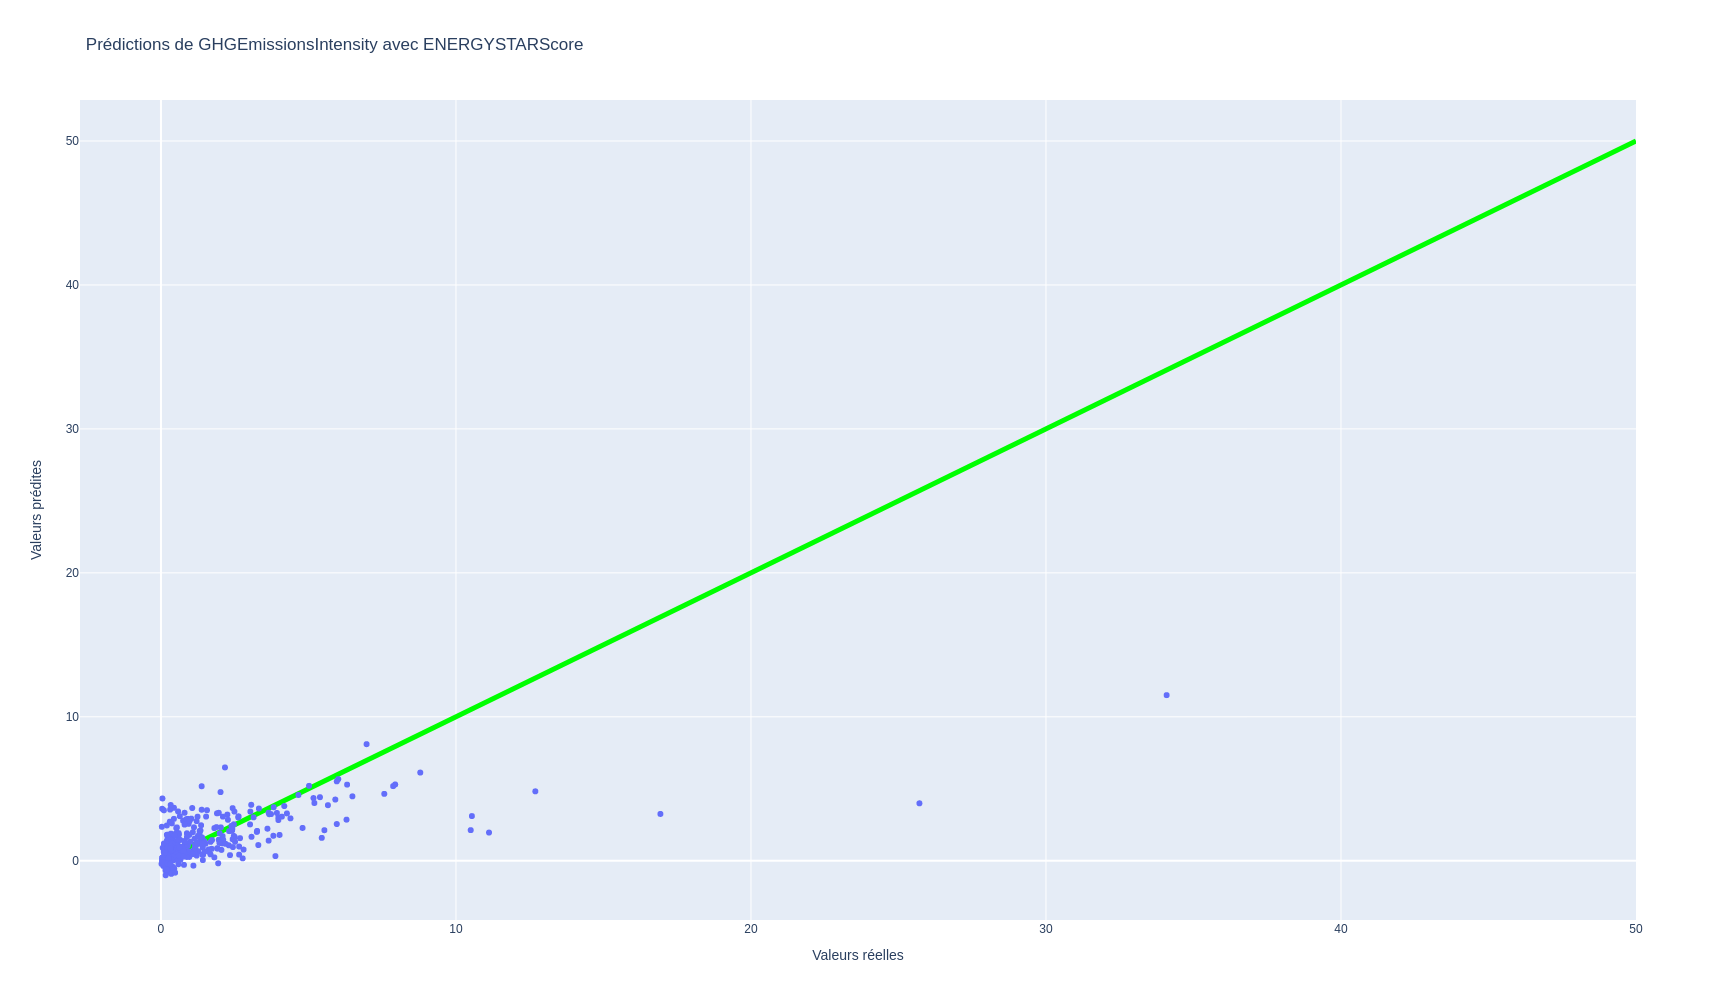

In [90]:
X_ = df.drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])

grid = joblib.load("working/best_siteeuiwn_with_energystarscore.pkl")
X_["predicted_euiwn"] = grid.predict(X_)

X = df.drop(columns=["GHGEmissionsIntensity", "SiteEUIWN(kBtu/sf)"])
X["predicted_euiwn"] = X_["predicted_euiwn"]
y = df[target]

X_train0, X_test0, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

grid2 = joblib.load("working/best_ghg_model_linear_use_lat_lon_0_use_property_types_0_use_energy_star_score_1.pkl")
y_predict = grid2.predict(X_test0)

fig1 = px.line(x=[0,50], y=[0,50])
fig1.update_traces(line=dict(color = 'rgba(0,255,0,1)', width=5))

fig2 = px.scatter(x=y_test, y=y_predict)

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width=1000,
    height=1000,
    title="Prédictions de GHGEmissionsIntensity avec ENERGYSTARScore",
    xaxis_title="Valeurs réelles",
    yaxis_title="Valeurs prédites"
)
fig.show()
